In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import pickle
import os
import sys

sys.path.append(os.path.abspath(os.path.join("..")))

import engine
import visual
import utils

# Procedures and Setup

In [48]:
rgb_green = (17/255, 119/255, 51/255)
rgb_skyblue = (136/255, 204/255, 238/255)
rgb_magenta = (170/255, 68/255, 153/255)
colors = [rgb_green, rgb_skyblue, rgb_magenta]

In [49]:
def compute_kdes(df, x_label, kde_method="sklearn"):
    
    kde_grid = np.arange(600)
    
    world_set = df["world"].unique()
    holes = [1,2,3]
    
    kde_dict = {}
    
    for world in world_set:
        world_dict = {}
        
        for hole in holes:
            
            samples = df[(df["world"] == world) &
                         (df["hole"] == hole)][x_label].to_numpy()
            
            if kde_method == "sklearn":
                kde = KernelDensity(kernel="gaussian", bandwidth=20).fit(samples[:,np.newaxis])
                hist = np.exp(kde.score_samples(kde_grid[:,np.newaxis]))
            elif kde_method == "FFTKDE":
                kde = FFTKDE(kernel="gaussian", bw=20).fit(samples)
                hist = kde.evaluate(kde_grid)
            else:
                raise Exception(f"KDE method {kde_method} not implemented.")
            
            world_dict[hole] = hist
            
        kde_dict[world] = world_dict
        
    return kde_dict

def plot_kdes(kde_dict, world_num, multiplier=8000, colors=colors, alpha=0.5, plot_gt=False, format="narrow", ax=None):

    kdes = kde_dict[world_num]

    if format == "narrow":

        if ax is None:
            _, ax = plt.subplots(1,1, figsize=(5,5))

        ax = visual.show_unity_trial(world_num, exp="prediction", ax=ax)

        for i, hole in enumerate([1,2,3]):

            kde = kdes[hole]
            ax = visual.graph_conditional_dist(ax, kde, multiplier=multiplier, col=colors[i], precomputed=True, alpha=alpha, zorder=0)

            trial = utils.load_trial(world_num, experiment="prediction", hole=hole)
            trial["drop_noise"] = 0
            trial["collision_noise_mean"] = 1.0
            trial["collision_noise_sd"] = 0.0

            if plot_gt:
                xs, ys, fp = visual.simulate_drop(trial, i)
                ax = visual.draw_drop(ax, i, trial, xs, ys, fp, colors=colors)
            else:
                ax = visual.draw_circle_drop(ax, i, trial, colors=colors)

    elif format == "wide":
        assert ax is None, "ax should be None for wide format"
        _, ax = plt.subplots(1,3, figsize=(15,5))

        for i, hole in enumerate([1,2,3]):

            trial = utils.load_trial(world_num, experiment="prediction", hole=hole)
            trial["drop_noise"] = 0
            trial["collision_noise_mean"] = 1.0
            trial["collision_noise_sd"] = 0.0

            if plot_gt:
                xs, ys, fp = visual.simulate_drop(trial, i)
                ax[i] = visual.draw_drop(ax[i], i, trial, xs, ys, fp, colors=colors)
            else:
                ax[i] = visual.draw_circle_drop(ax[i], i, trial, colors=colors)
            
            sub_ax = ax[i]
            kde = kdes[hole]
            
            sub_ax = visual.show_unity_trial(world_num, exp="prediction", ax=sub_ax)
            sub_ax = visual.graph_conditional_dist(sub_ax, kde, multiplier=multiplier, col=colors[i], precomputed=True, alpha=alpha)

    else:
        raise Exception(f"Format {format} not implemented.")
    
    return ax

def plot_trials(kde_dict, sample_worlds):
    _, axes = plt.subplots(1, len(sample_worlds), figsize=(15,5))

    for i, world_num in enumerate(sample_worlds):
        ax = axes[i]
        ax = plot_kdes(kde_dict, world_num, alpha=0.7, plot_gt=False, format="narrow", ax=ax)

    return axes

# Load Data and Model Performance

In [50]:
human_data = pd.read_csv("../../../data/human_data/prediction/prediction_long.csv").drop("Unnamed: 0", axis=1)
human_data

participant  order  trial  hole  world  click  response
0                1     41      1     1      2      1     124.5
1                1     41      1     1      2      2     124.5
2                1     41      1     1      2      3     124.5
3                1     41      1     1      2      4     124.5
4                1     41      1     1      2      5     124.5
...            ...    ...    ...   ...    ...    ...       ...
53995           45     72    120     3    118      6     466.5
53996           45     72    120     3    118      7     466.5
53997           45     72    120     3    118      8     466.5
53998           45     72    120     3    118      9     466.5
53999           45     72    120     3    118     10     466.5

[54000 rows x 7 columns]

In [51]:
world_nums = human_data["world"].unique()
world_nums

array([  2,   6,   9,  10,  12,  13,  14,  16,  20,  26,  27,  32,  38,
        42,  45,  47,  48,  50,  56,  59,  62,  70,  74,  80,  82,  84,
        86,  90,  91,  92,  94,  99, 104, 105, 109, 111, 112, 113, 115,
       118])

In [52]:
human_kde_dict = compute_kdes(human_data, "response", kde_method="sklearn")

In [53]:
sim_model_pred = pd.read_csv("grid_search/prediction_0.3_drop_noise_0.0_col_mean_0.7_col_sd_100_sims.csv").drop("Unnamed: 0", axis=1)
sim_model_pred

world  hole  sim       x_pos
0          2     1    0   70.051973
1          2     1    1  235.633131
2          2     1    2   85.997599
3          2     1    3   92.296837
4          2     1    4  140.453562
...      ...   ...  ...         ...
11995    118     3   95  424.818086
11996    118     3   96  460.794850
11997    118     3   97  441.165267
11998    118     3   98  463.450801
11999    118     3   99  438.786161

[12000 rows x 4 columns]

In [54]:
sim_kde_dict = compute_kdes(sim_model_pred, "x_pos", kde_method="sklearn")

# Model Visuals

### Figure 2 A

70


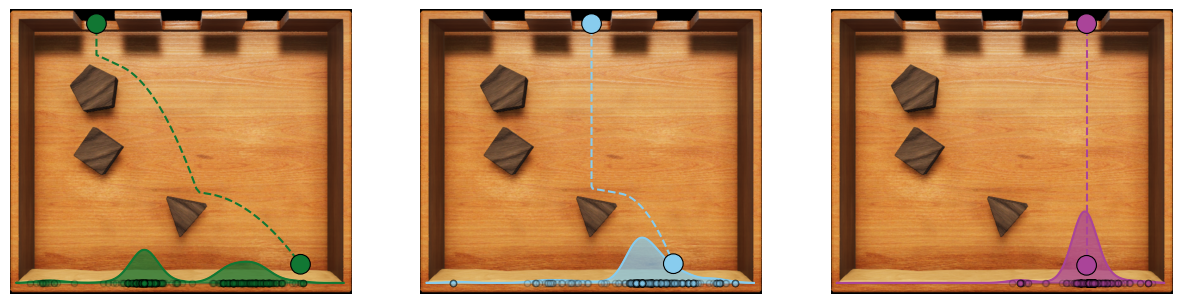

In [55]:
world_num = world_nums[21]
print(world_num)

df_tr = human_data[human_data["world"] == world_num]

ax = plot_kdes(human_kde_dict, world_num, alpha=0.7, plot_gt=True, format="wide")

for i, hole in enumerate([1,2,3]):
    df_hole = df_tr[df_tr["hole"] == hole]
    ax[i].scatter(df_hole["response"], [480]*df_hole.shape[0], color=colors[i], edgecolors="black", alpha=0.2, s=20)

### Figure 2 B

In [56]:
np.random.seed(5)
world = utils.load_trial(world_num, experiment="prediction", hole=1, drop_noise=0.3, col_mean=0.1, col_sd=0.8)

sims = []
sim_mat = np.zeros((3, 100))
for hole in [0,1,2]:
    world["hole_dropped_into"] = hole

    hole_sims = []

    for sim in range(100):
        sim_data = engine.run_simulation(world, convert_coordinates=True)
        hole_sims.append([(pos["x"], 500 - pos["y"]) for pos in sim_data["ball_position"]])
        x_pos = sim_data["ball_position"][-1]["x"]
        sim_mat[hole, sim] = x_pos

    sims.append(hole_sims)

In [57]:
trial_kdes = {}
for i in range(3):
    kde = KernelDensity(kernel="gaussian", bandwidth=20).fit(sim_mat[i,:][:,np.newaxis])
    hist = np.exp(kde.score_samples(np.arange(600)[:,np.newaxis]))
    trial_kdes[i+1] = hist

sample_trial_kdes = {world_num: trial_kdes}

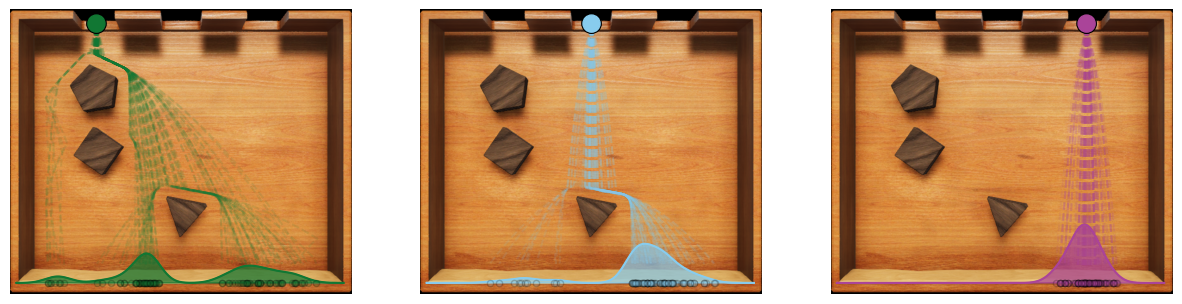

In [58]:
ax = plot_kdes(sample_trial_kdes, world_num, colors=colors, alpha=0.7, plot_gt=False, format="wide")

for i, hole in enumerate([1,2,3]):
    ax[i].scatter(sim_mat[i], [480]*sim_mat.shape[1], color=colors[i], edgecolors="black", alpha=0.2, s=20)

    for sim in range(100):
        xs, ys = zip(*sims[i][sim])
        ax[i].plot(xs, ys, "--", color=colors[i], alpha=0.1, zorder=1)

### Figure 2 C

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

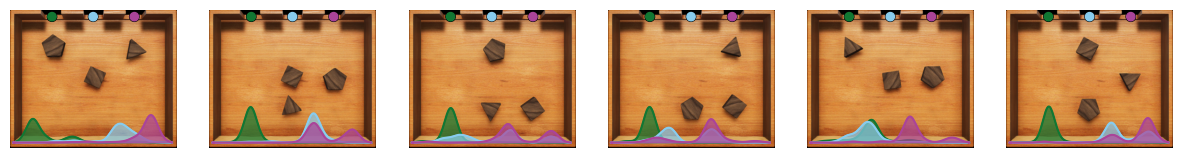

In [59]:
sample_worlds = [2, 26, 32, 42, 104, 112]

plot_trials(human_kde_dict, sample_worlds)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

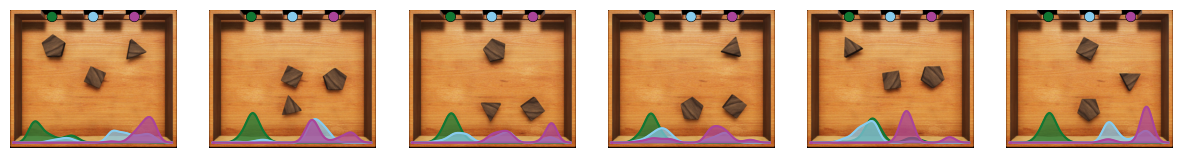

In [60]:
plot_trials(sim_kde_dict, sample_worlds)

## Appendix Figure

In [61]:
# sim models
full_model_kde_dict = sim_kde_dict

df_dno = pd.read_csv("grid_search/prediction_0.3_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv").drop("Unnamed: 0", axis=1)
dno_kde_dict = compute_kdes(df_dno, "x_pos", kde_method="sklearn")

df_cno = pd.read_csv("grid_search/prediction_0.0_drop_noise_0.0_col_mean_0.6_col_sd_100_sims.csv").drop("Unnamed: 0", axis=1)
cno_kde_dict = compute_kdes(df_cno, "x_pos", kde_method="sklearn")

In [63]:
# stat models
linear_filepath = "saved_model_pred/linear_w_pretraining_alldata.p"
with open(linear_filepath, "rb") as f:
    linear = pickle.load(f)

mlp_filepath = "saved_model_pred/mlp_w_pretraining_alldata.p"

with open(mlp_filepath, "rb") as f:
    mlp = pickle.load(f)

cnn_filepath = "saved_model_pred/cnn_w_pretraining_alldata.p"
with open(cnn_filepath, "rb") as f:
    cnn = pickle.load(f)

linear_kde_dict = linear[0]["kde_dicts"]
mlp_kde_dict = mlp[0]["kde_dicts"]
cnn_kde_dict = cnn[0]["kde_dicts"]

In [64]:
with open("saved_model_pred/below_hole_kde_dict.pkl", "rb") as f:
    below_hole_kde_dict = pickle.load(f)

with open("saved_model_pred/gt_kde_dict.pkl", "rb") as f:
    gt_kde_dict = pickle.load(f)

In [65]:
kde_dicts_all_models = [human_kde_dict,
                        full_model_kde_dict, 
                        dno_kde_dict,
                        cno_kde_dict,
                        gt_kde_dict,
                        below_hole_kde_dict,
                        linear_kde_dict,
                        mlp_kde_dict,
                        cnn_kde_dict]

model_names = ["Human",
               "IPE",
               "No Drop Noise",
               "No Collision Noise",
               "No Noise Model",
               "Under Hole Model",
               "Linear Model",
               "Non-Linear Restricted Depth",
               "Multi-Layer Non-Linear"]

In [66]:
def show_model_pred(world_num, kde_dicts_all_models):

    _, axes = plt.subplots(9, 1, figsize=(5, 27))
    for i, kde_dict in enumerate(kde_dicts_all_models):
        ax = axes[i]
        ax = plot_kdes(kde_dict, world_num, colors=colors, alpha=0.7, plot_gt=False, format="narrow", ax=ax)
        ax.set_xlabel("X Position")
        ax.set_ylabel("Y Position")

    return axes

### Trial 1

In [70]:
disp_trials = world_nums[:6]

array([<Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>], dtype=object)

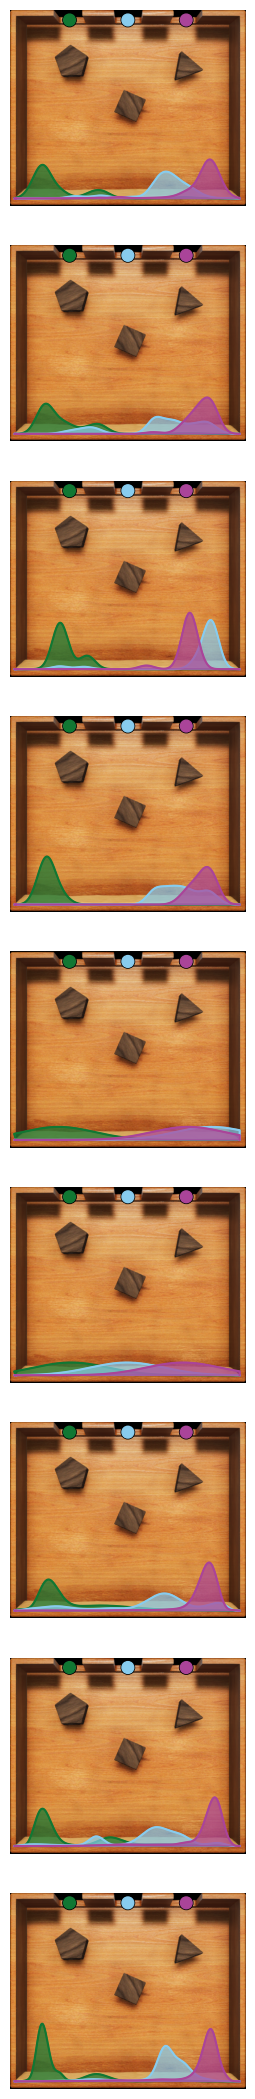

In [71]:
show_model_pred(disp_trials[0], kde_dicts_all_models)

### Trial 2

array([<Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>], dtype=object)

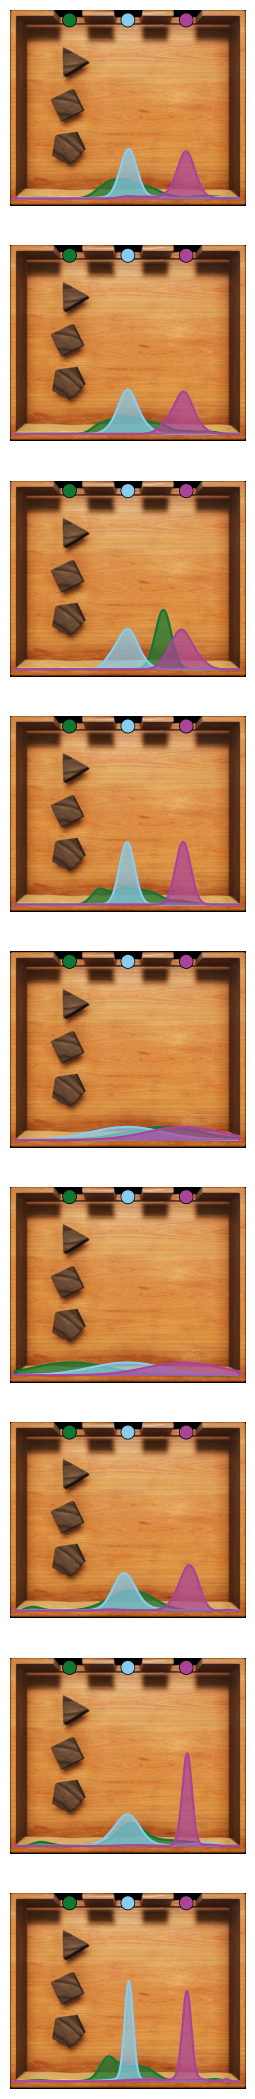

In [72]:
show_model_pred(disp_trials[1], kde_dicts_all_models)

### Trial 3

array([<Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>], dtype=object)

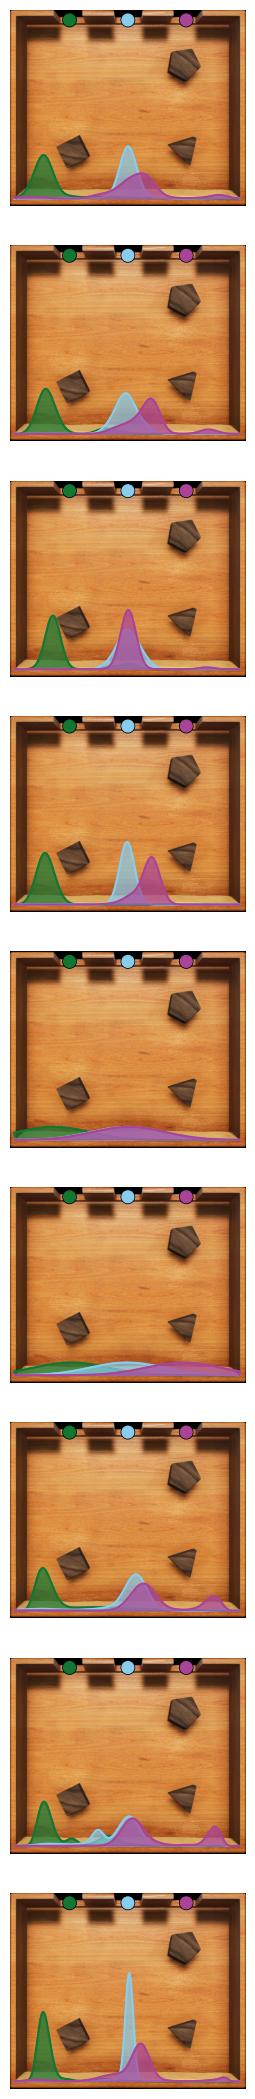

In [73]:
show_model_pred(disp_trials[2], kde_dicts_all_models)

### Trial 4

array([<Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>], dtype=object)

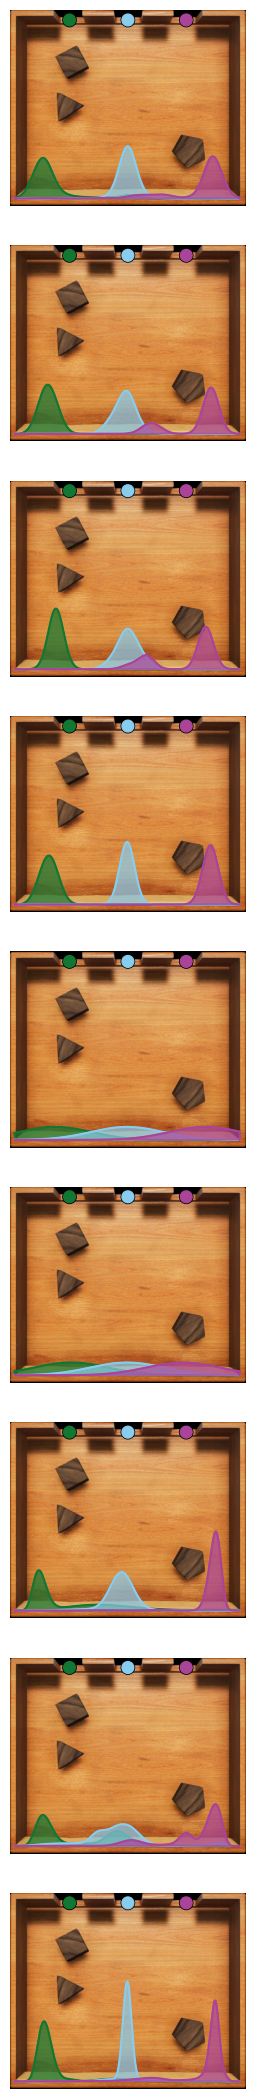

In [74]:
show_model_pred(disp_trials[3], kde_dicts_all_models)

### Trial 5

array([<Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>], dtype=object)

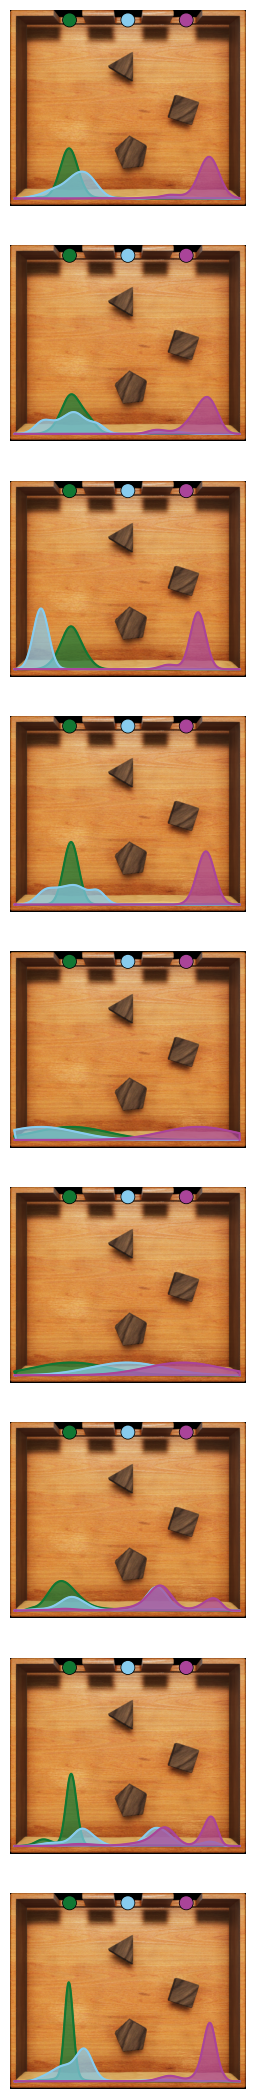

In [75]:
show_model_pred(disp_trials[4], kde_dicts_all_models)

### Trial 6

array([<Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>,
       <Axes: xlabel='X Position', ylabel='Y Position'>], dtype=object)

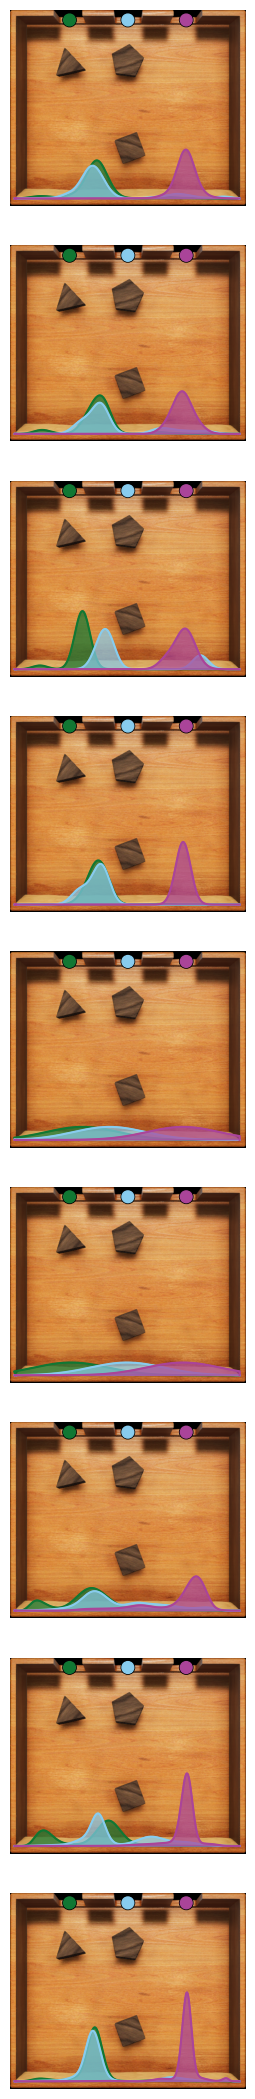

In [76]:
show_model_pred(disp_trials[5], kde_dicts_all_models)